# SET Game: Analyzing Learned Encodings and Relation Functions w.r.t. Base Attributes

## Set Up

In [1]:
import itertools

import numpy as np

import sklearn.model_selection
import sklearn.metrics

import seaborn as sns
import pandas as pd

from tqdm.auto import tqdm

import wandb

import tensorflow as tf

# %load_ext autoreload
# %autoreload 2
import sys; sys.path.append('..')
from relational_neural_networks.relational_neural_networks import *
from relational_neural_networks.utils import *

import set_game

In [2]:
api = wandb.Api()

In [3]:
import matplotlib
plt.rcParams.clear()

# plt.style.use('default')
plt.style.use('seaborn')

In [4]:
entity_space = set_game.entity_space
entity_space_enc = np.array([set_game.encode_entity(entity) for entity in entity_space]).astype(float)

# create space of combinations of two entities
pair_space = list(itertools.combinations(entity_space, 2))

def attr_is_same(attr, x, y):
    return x[attr]==y[attr]

attr0_same = [attr_is_same(0, x, y) for (x,y) in pair_space]
attr1_same = [attr_is_same(1, x, y) for (x,y) in pair_space]
attr2_same = [attr_is_same(2, x, y) for (x,y) in pair_space]
attr3_same = [attr_is_same(3, x, y) for (x,y) in pair_space]

attr_sameness = np.array([attr0_same, attr1_same, attr2_same, attr3_same]).T

In [5]:
def plot_encoder(encoder, axs, dim_red='pca'):

    encoded_entities = encoder(entity_space_enc)
    if dim_red=='pca':
        dim_red = sklearn.decomposition.PCA(n_components=2)
    elif dim_red=='tsne':
        dim_red = sklearn.manifold.TSNE(n_components=2, init='pca')
    else:
        raise ValueError('dim_red invalid')

    encoded_entities_2d = dim_red.fit_transform(encoded_entities)

    for attr, ax in zip(range(4), axs):
        attr_vals = np.array(entity_space)[:, attr]

        cmap = matplotlib.colors.ListedColormap(plt.get_cmap('Set1').colors[:3])
        scatter = ax.scatter(encoded_entities_2d[:,0], encoded_entities_2d[:, 1], c=attr_vals, cmap=cmap, s=50, alpha=0.5)
        ax.set_title(f'Attribute {attr}')
        legend = ax.legend(*scatter.legend_elements(),
                        loc="upper right", title="Attribute Values")
        ax.add_artist(legend)

def plot_encoders(encoders, dim_red='pca'):
    '''plote each encoder's encodings against attributes via dimensionality reduction'''

    fig, axs = plt.subplots(ncols=4, nrows=len(encoders), figsize=(16, 4*len(encoders)))

    for i, encoder in enumerate(encoders):
        plot_encoder(encoder, axs[i], dim_red='pca')
        axs[i][0].set_ylabel(f'Encoder {i}')


In [6]:
def compute_pair_rels_1d(encoder):
    x1_enc = np.array([set_game.encode_entity(tuple(ent)) for ent in np.array(pair_space)[:, 0, :]]).astype(float)
    x2_enc = np.array([set_game.encode_entity(tuple(ent)) for ent in np.array(pair_space)[:, 1, :]]).astype(float)

    z1_enc = encoder(x1_enc).numpy()
    z2_enc = encoder(x2_enc).numpy()

    rels = np.array([np.inner(z1, z2) for (z1, z2) in zip(z1_enc, z2_enc)])

    return rels

def compute_pair_rels(encoders):
    '''computes relation vector induced by encoders for each pair of entities'''
    rels = np.stack([compute_pair_rels_1d(encoder) for encoder in encoders], axis=1)
    return rels

def plot_relation_attr_sameness(encoders, dim_red='pca'):
    '''project relation vectors onto 2-d space then plate against sameness of each attr'''

    rels = compute_pair_rels(encoders)

    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,3))


    if dim_red=='pca':
        dim_red = sklearn.decomposition.PCA(n_components=2)
    elif dim_red=='tsne':
        dim_red = sklearn.manifold.TSNE(n_components=2, init='pca')
    else:
        raise ValueError('dim_red invalid')

    for attr in range(attr_sameness.shape[1]):

        encoded_entities_2d = dim_red.fit_transform(rels)

        for attr, ax in zip(range(4), axs):
            attr_i_sameness = attr_sameness[:, attr]

            cmap = matplotlib.colors.ListedColormap(plt.get_cmap('Set1').colors[:2])
            scatter = ax.scatter(encoded_entities_2d[:,0], encoded_entities_2d[:, 1], c=attr_i_sameness, cmap=cmap, s=50, alpha=0.5)
            ax.set_title(f'Attribute {attr}')
            legend = ax.legend(*scatter.legend_elements(),
                            loc="upper right", title="Attribute is Same")
            ax.add_artist(legend)
            ax.set_xlabel('$\hat{R}(x,y)$ [projected dim1]')
        axs[0].set_ylabel('$\hat{R}(x,y)$ [projected dim2]')

def rel_attr_pairplot(encoders):
    '''plots pairplot of relations against attribute samenss'''
    rels = compute_pair_rels(encoders)

    rels_df = pd.DataFrame(rels, columns=[f'rel_{i}' for i in range(rels.shape[1])])
    attr_sameness_df = pd.DataFrame(attr_sameness, columns=[f'attr_{i}_same' for i in range(attr_sameness.shape[1])])
    rels_sameness = rels_df.merge(attr_sameness_df, left_index=True, right_index=True)

    sns.pairplot(rels_sameness, x_vars=rels_df.columns, y_vars=attr_sameness_df.columns, corner=True, plot_kws={'alpha':0.05, 's': 25})

In [7]:
# NOTE: (TEMP/FIXME): I didn't implement get_config and from_config,
# so I need a hacky fix to get the intermediate layers in the models to work

def get_mlp_encoders(entity_encoders):
    # in these initial experiments, MLPs are single dense layer...

    return [entity_encoder.encoder.layers[0] for entity_encoder in entity_encoders]

def get_lin_proj_encoders(entity_encoders):
    lin_proj_encs = []
    for entity_encoder in entity_encoders:
        lin_proj_enc = LinearProjectionEncoder()
        lin_proj_enc.build(input_shape=(12,))
        lin_proj_enc.set_weights(entity_encoder.encoder.weights)
        lin_proj_encs.append(lin_proj_enc)

    return lin_proj_encs


## RelNN (MLP encoder)

In [8]:
artifact = api.artifact('awni00/RelNN/model-lyric-dream-29:v20', type='model')
artifact_dir = artifact.download()

relnn_mlp_enc = tf.keras.models.load_model(artifact_dir)
relnn_mlp_enc.summary()

wandb:   4 of 4 files downloaded.  


Model: "relnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_entity_seq (InputLaye  [(None, 3, 12)]          0         
 r)                                                              
                                                                 
 rel_layer (RelationalLayer)  (None, 3, 3, 4)          208       
                                                                 
 flatten (Flatten)           (None, 36)                0         
                                                                 
 dense (Dense)               (None, 16)                592       
                                                                 
 output (Dense)              (None, 2)                 34        
                                                                 
Total params: 834
Trainable params: 834
Non-trainable params: 0
_______________________________________________________________

In [9]:
encoders = get_mlp_encoders(relnn_mlp_enc.get_layer('rel_layer').entity_encoders)

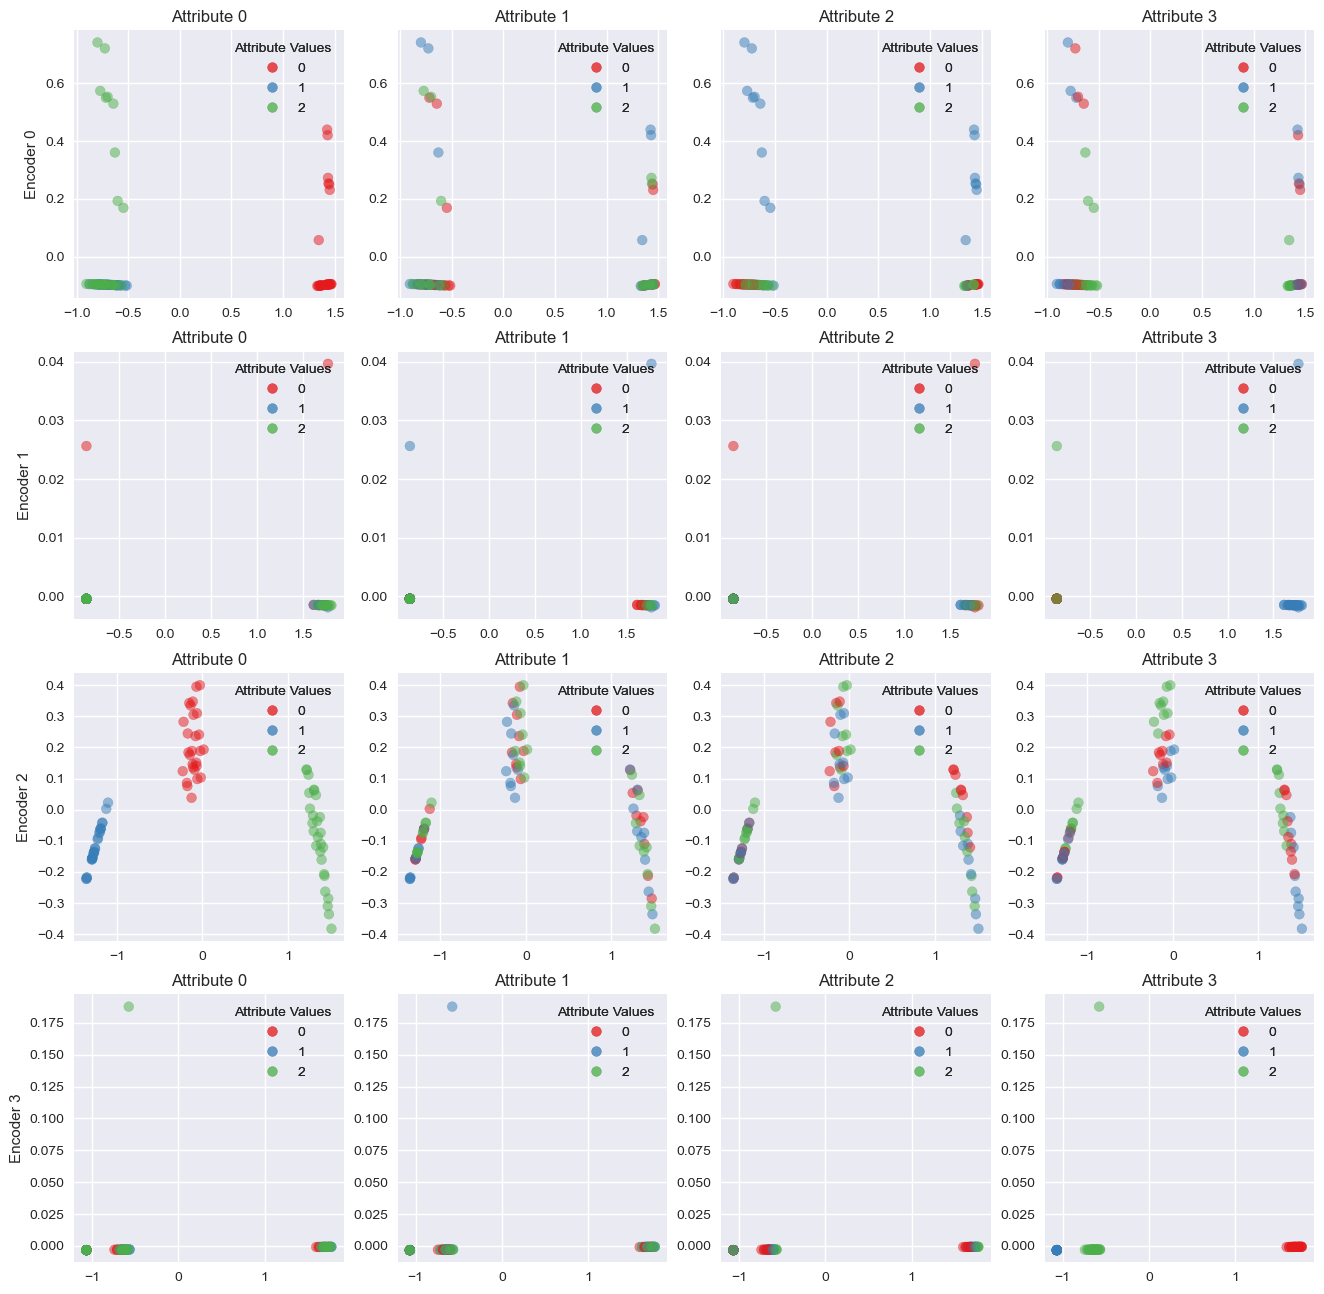

In [10]:
plot_encoders(encoders, dim_red='tsne')

**Observations:** Encoder 2 clearly separates attribute 0. Encoder 0 also partially separates attribute 0. Encoder 3 separates attribute 3. The rest are less obvious.

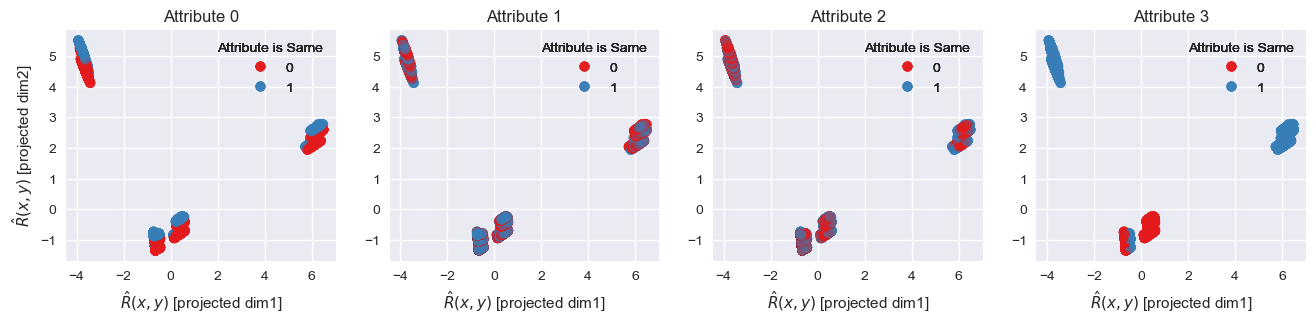

In [11]:
plot_relation_attr_sameness(encoders, dim_red='pca')

**Observations:** Sameness of attribute 3 seems to be discernable from the learned relation function. There is also structure in the sameness of attribute 0. The rest are less clear.

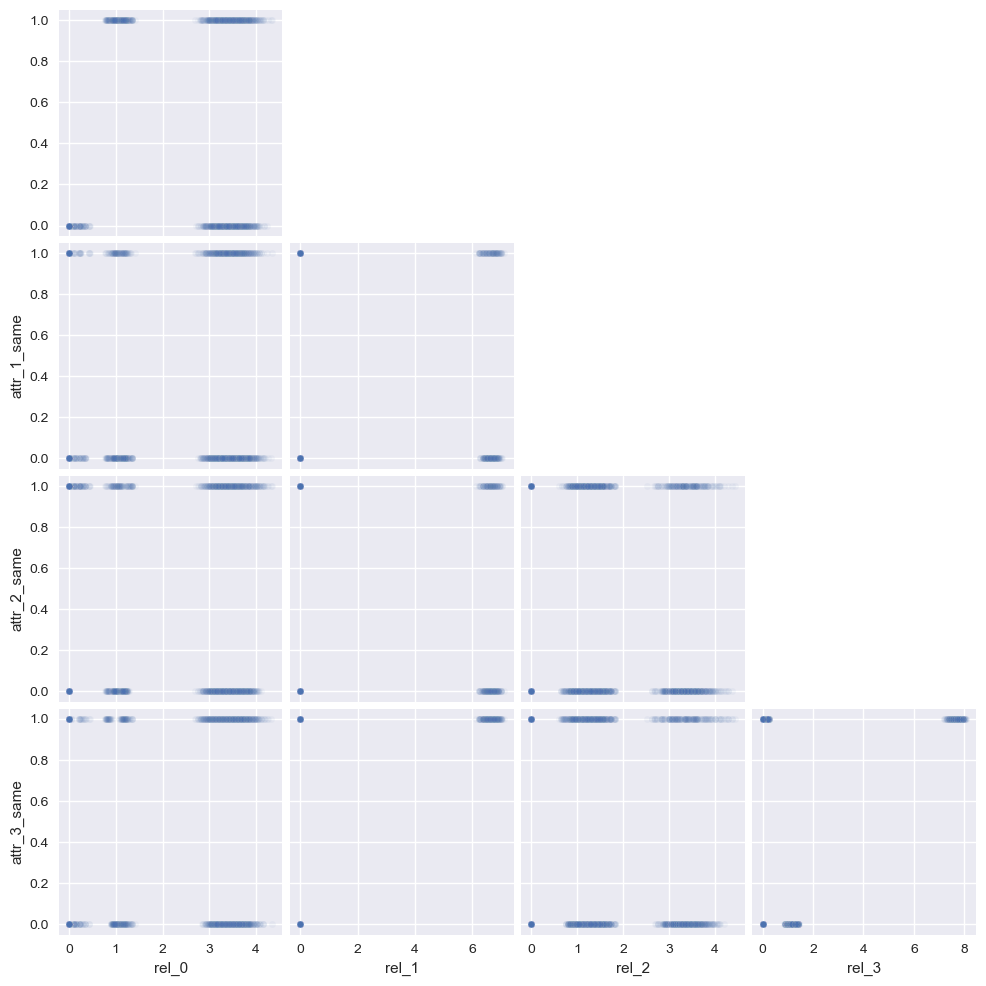

In [12]:
rel_attr_pairplot(encoders)

## RelNN (Linear Projection)

In [13]:
artifact = api.artifact('awni00/RelNN/model-divine-frost-31:v18', type='model')
artifact_dir = artifact.download()

relnn_linproj = tf.keras.models.load_model(artifact_dir)
relnn_linproj.summary()

wandb:   4 of 4 files downloaded.  


Model: "relnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_entity_seq (InputLaye  [(None, 3, 12)]          0         
 r)                                                              
                                                                 
 rel_layer (RelationalLayer)  (None, 3, 3, 4)          48        
                                                                 
 flatten (Flatten)           (None, 36)                0         
                                                                 
 dense (Dense)               (None, 16)                592       
                                                                 
 output (Dense)              (None, 2)                 34        
                                                                 
Total params: 674
Trainable params: 674
Non-trainable params: 0
_______________________________________________________________

In [14]:
encoders = get_lin_proj_encoders(relnn_linproj.get_layer('rel_layer').entity_encoders)

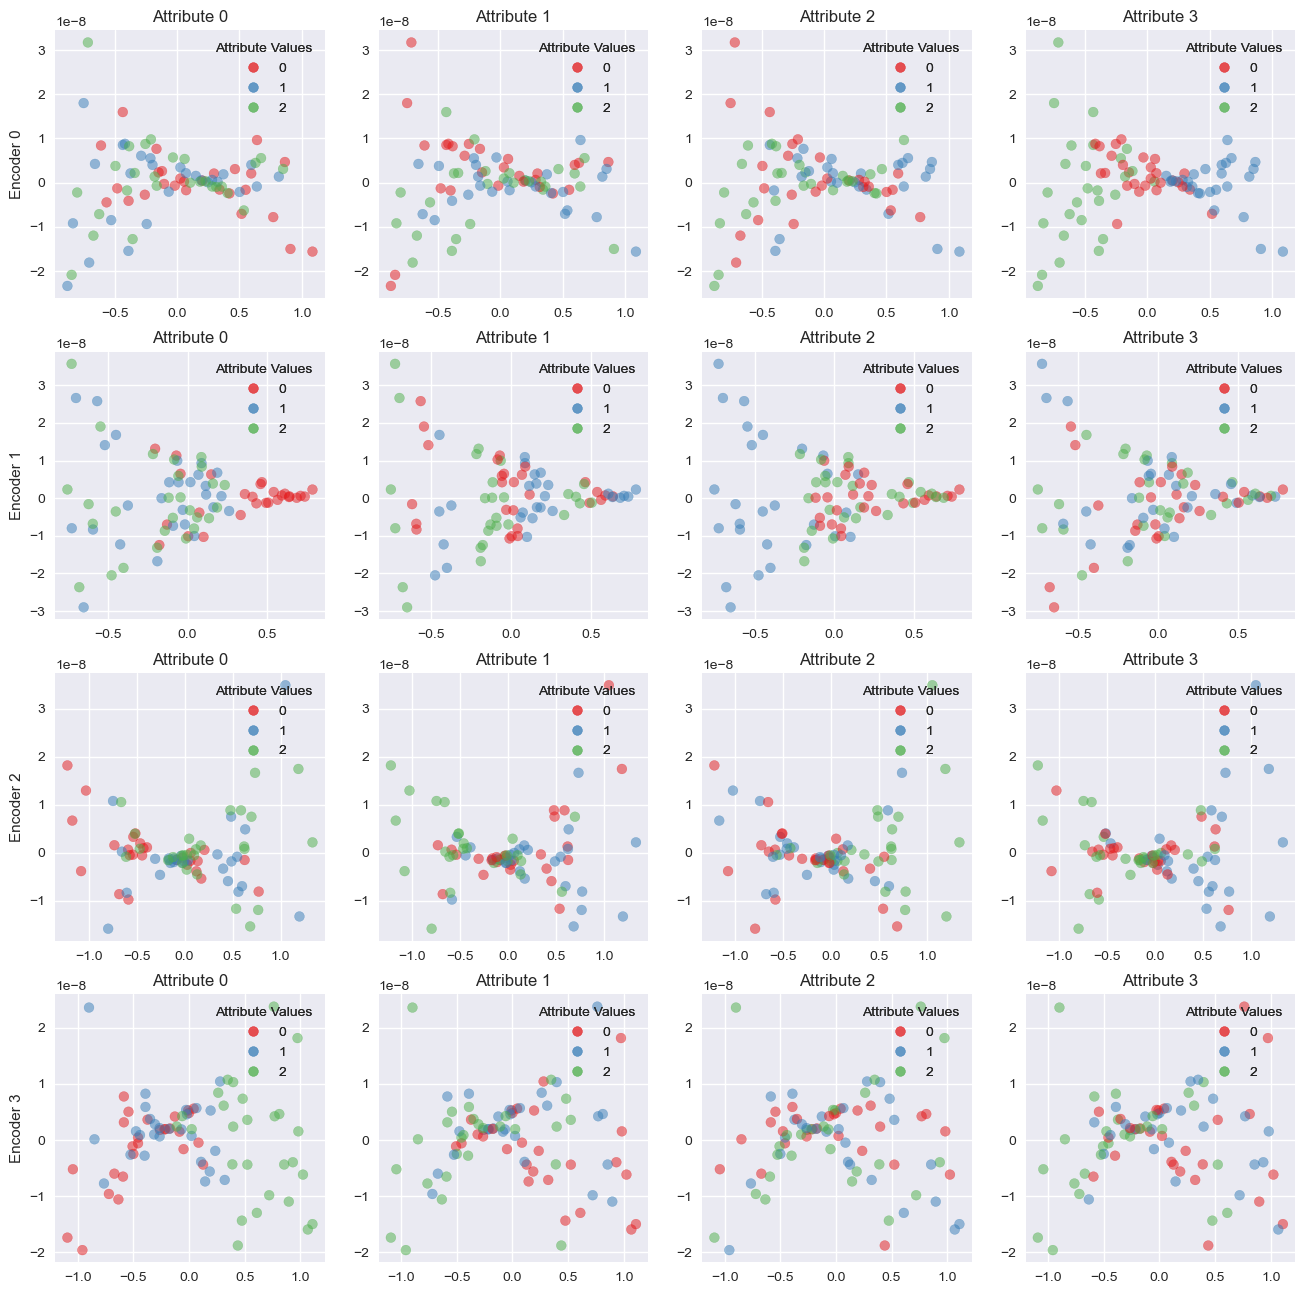

In [15]:
plot_encoders(encoders, dim_red='pca')

**Observations:** Note that the projection subspace is one dimensional, so only the x-axis is relevant. Encoder 3 seemse to separate attribute 0. Encoder 1 also (partially separates) attribute 0. Encoder 0 separates attribute 3. Encoder 1 partially separates attribute 2. Some information about attribute 1 is contained in all encoders.

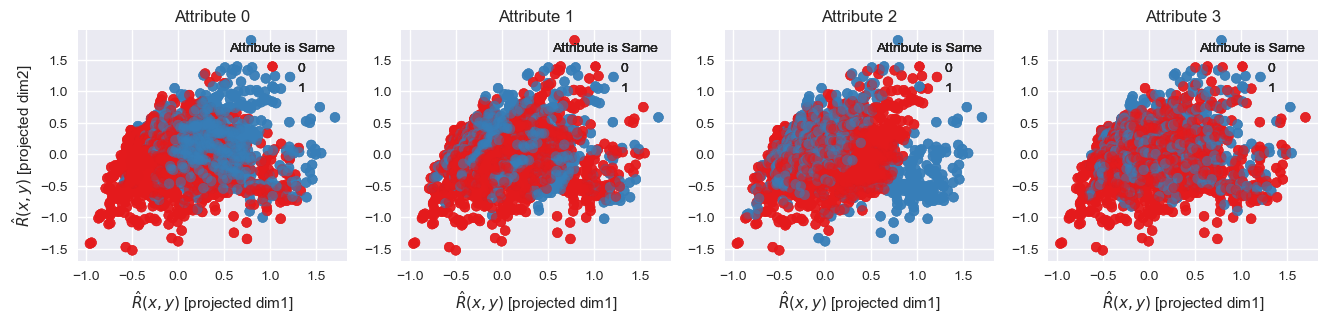

In [16]:
plot_relation_attr_sameness(encoders, dim_red='pca')

**Observations:** The learned linear projections clearly separate sameness of attribute 0. There is also clear structure in the separation of attribute 1 and 2. Attribute 3 is more mixed, but there is still some relationship.

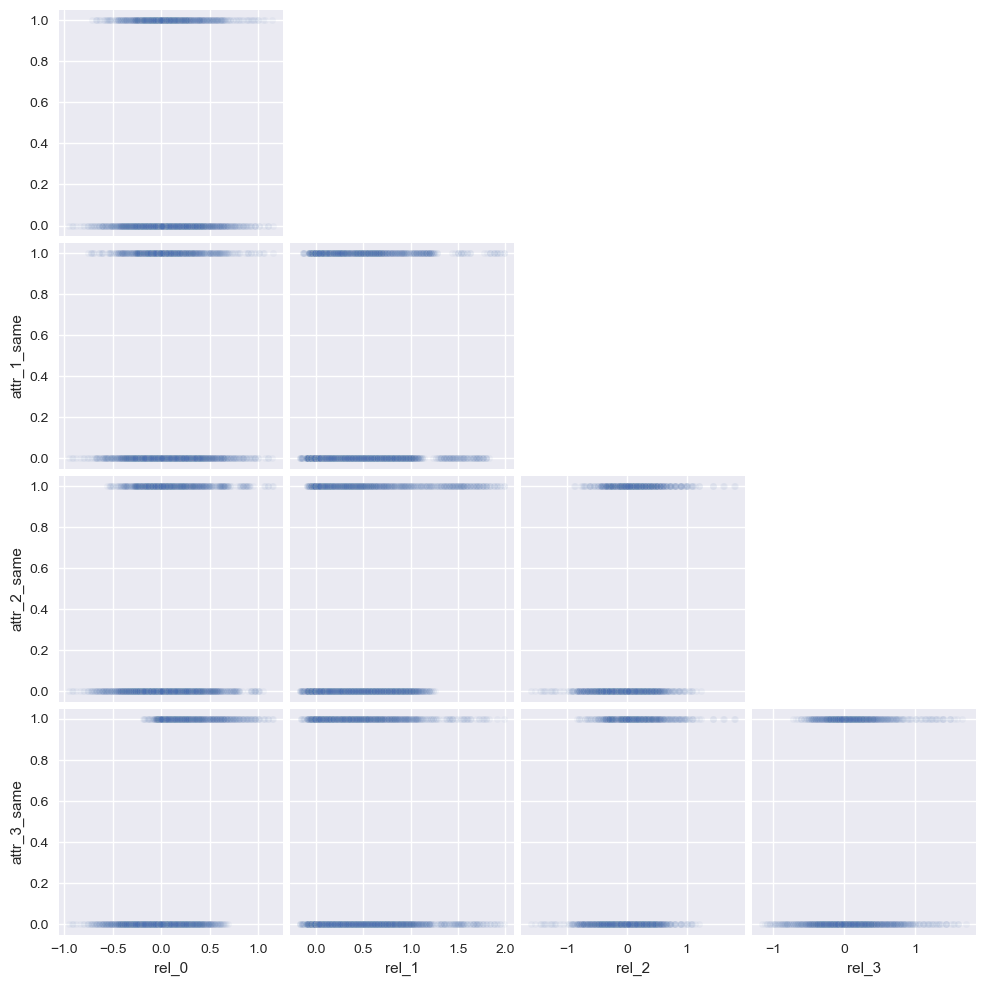

In [17]:
rel_attr_pairplot(encoders)